In [135]:
import numpy
import scipy.sparse
from scipy.sparse.linalg import spsolve

import quadpy

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import meshio
import igl

from aabbtree import AABB, AABBTree

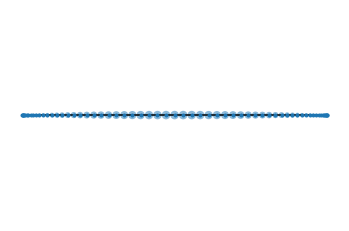

1.0000000000001612

In [179]:
# some quadrature rule
scheme = quadpy.c1.gauss_patterson(5)
scheme.show()
scheme.integrate(lambda x: numpy.ones(x.shape[0]), [0.0, 1.0])

In [137]:
def point_edge_coord(p, e0, e1):
    e = e1 - e0
    return (p - e0).dot(e) / e.dot(e)

def point_edge_distance(p, e0, e1):
    t = numpy.clip(point_edge_coord(p, e0, e1), 0, 1)
    d = p - ((e1 - e0) * t + e0)
    return d.dot(d)

def point_on_edge(p, e0, e1):
    return point_edge_distance(p, e0, e1) < 1e-8

## Meshes

In [138]:
V_coarse = numpy.array([
    [0, 0, 0],
    [1, 0, 0],
    [1, 1, 0],
    [0, 1, 0],
], dtype=float)

E_coarse = numpy.array([
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 0],
])

m = V_coarse.shape[0]
n = 3
alphas = numpy.linspace(0, 1, n + 2)[1:-1]
V_fine = numpy.vstack(
    list(V_coarse) + 
    [(v1 - v0) * alpha + v0 for v0, v1 in V_coarse[E_coarse] for alpha in alphas]
)
# V_fine += 0.1 * numpy.random.random(V_fine.shape)

E_fine = []
for i in range(m):
    for j in range(n + 1):
        E_fine.append([
            i if j == 0 else (m - 1) + n * i + j, 
            ((i + 1) % m) if j == n else (m - 1) + n * i + j + 1])
E_fine = numpy.array(E_fine)

In [139]:
coarse_mesh = meshio.read("../meshes/2D/kangaroo/kangaroo_coarse.msh")
V_coarse = coarse_mesh.points
E_coarse = igl.boundary_facets(coarse_mesh.cells[0].data.astype(int))
V_coarse, E_coarse, *_ = igl.remove_unreferenced(V_coarse, E_coarse[:, [0, 1, 1]])
E_coarse = E_coarse[:, :2]

fine_mesh = meshio.read("../meshes/2D/kangaroo/kangaroo_fine.msh")
V_fine = fine_mesh.points
E_fine = igl.boundary_facets(fine_mesh.cells[0].data.astype(int))
V_fine, E_fine, *_ = igl.remove_unreferenced(V_fine, E_fine[:, [0, 1, 1]])
E_fine = E_fine[:, :2]

print(V_coarse.shape, len(set(E_coarse.flatten())))
print(V_fine.shape, len(set(E_fine.flatten())))

(176, 3) 176
(314, 3) 314


In [140]:
U_coarse = numpy.zeros(V_coarse.shape)
# U_coarse[V_coarse[:, 0] > 0.999, 1] = 1
U_coarse[:, 1] += numpy.sin(0.5 * numpy.pi * V_coarse[:, 0])
U_fine = numpy.zeros(V_fine.shape)
# U_fine[V_fine[:, 0] > 0.999, 1] = 1
U_fine[:, 1] += numpy.sin(0.5 * numpy.pi * V_fine[:, 0])

In [141]:
coarse_coll = False
if coarse_coll:
    V_coll, V_fem = V_coarse, V_fine
    E_coll, E_fem = E_coarse, E_fine
    U_coll, U_fem = U_coarse, U_fine
else:
    V_coll, V_fem = V_fine, V_coarse
    E_coll, E_fem = E_fine, E_coarse
    U_coll, U_fem = U_fine, U_coarse

# V_fem = V_coll
# E_fem = E_coll
# U_fem = U_coll

## Upsample-Downsample Method

In [142]:
def upsample(V, E, edge_splits):
    alphas = numpy.linspace(0, 1, edge_splits + 2)[1:-1]
    upsampled_V = [V]
    downsample_buddy = [[[i, 1]] for i in range(V.shape[0])]
    i= V.shape[0]
    for e in E:
        v0, v1 = V[e]
        for alpha in alphas:
            downsample_buddy[e[0]].append([i, 1-alpha])
            downsample_buddy[e[1]].append([i, alpha])
            upsampled_V.append((v1 - v0) * alpha + v0)
            i += 1
    return numpy.vstack(upsampled_V), downsample_buddy

In [143]:
def compute_W(V_coll, V_fem, E_fem):
    W = numpy.zeros((V_coll.shape[0], V_fem.shape[0]))

    for i, v in enumerate(V_coll):
        ds = numpy.array([point_edge_distance(v, e0, e1) for e0, e1 in V_fem[E_fem]])
        ei = ds.argmin()
        e = E_fem[ei]
        e0, e1 = V_fem[e]
        t = numpy.clip(point_edge_coord(v, e0, e1), 0, 1)
        W[i, e[0]] = 1 - t
        W[i, e[1]] = t

    print(numpy.linalg.norm(V_coll - W @ V_fem))
    return W

In [144]:
def downsample(W, downsample_buddies):
    W_downsampled = numpy.vstack([
        # W[i] + W[buddies].sum(axis=0)
        sum(weight * W[buddy] for buddy, weight in buddies)
        for buddies in downsample_buddies])
    W_downsampled /= W_downsampled.sum(axis=1)[:, None]
    return W_downsampled

In [145]:
# edge_splits = 10
# V_coll_upsampled, downsample_buddy = upsample(V_coll, E_coll, edge_splits)
# W = compute_W(V_coll_upsampled, V_fem, E_fem)
# W_new = downsample(W, downsample_buddy)

## L2 Projection

In [146]:
def hat_phi0(x):
    return 1-x
def hat_phi1(x):
    return x

In [147]:
def build_bases(V, E):
    return [{
        "n_bases": 2,
        # 2 bases
        "phi": [hat_phi0, hat_phi1],
        # local to global mapping
        "loc_2_glob": e.tolist(),
        # geometric mapping
        "gmapping": lambda x, e=e: (V[e[1]] - V[e[0]]) * x + V[e[0]],
        "grad_gmapping": lambda _: numpy.linalg.norm(V[e[1]]-V[e[0]]),
    } for e in E]

In [148]:
def compute_mass_mat(elements):
    rows, cols, vals = [], [], []
    
    # same as above but now we use phi instead of grad_phi and no division
    for el in elements:
        for i, phi_i in enumerate(el["phi"]):
            for j, phi_j in enumerate(el["phi"]):
                # ∫_{ŝ_j} ϕ̂ᵢ⋅ϕ̂ⱼ \,(s_{j, 1} - s_{j, 0})
                val = scheme.integrate(
                    lambda x: phi_i(x) * phi_j(x) * el["grad_gmapping"](x),
                    [0.0, 1.0])

                rows.append(el["loc_2_glob"][i])
                cols.append(el["loc_2_glob"][j])
                vals.append(val)

    return scipy.sparse.coo_matrix((vals, (rows, cols))).tocsc()
    

In [149]:
def find_and_eval(pt, bases, poly, E, tree):
    assert(len(bases) == len(poly))
    
    limits = numpy.vstack([pt, pt]).T
    eis = tree.overlap_values(AABB(limits))
    if(len(eis) == 0):
        eis = numpy.arange(E.shape[0])

    distances = numpy.array([
        point_edge_distance(pt, e0, e1) for e0, e1 in poly[E[eis]]
    ])

    # find the closest element index
    index = eis[distances.argmin()]
    # find the coords of the closest point in the closest element
    closest_point = point_edge_coord(pt, *poly[E[index]])
    
    el = bases[index]
    return [
        (el["loc_2_glob"][j], el["phi"][j](closest_point))
        for j in range(el["n_bases"])
    ]

In [150]:
def compute_mass_mat_cross(a, b, poly_b, e_b, shape):
    rows, cols, vals = [], [], []
    
    q_pts = (scheme.points+1)/2 # [-1, 1] -> [0, 1]
    q_w = scheme.weights/2 # sum(w) = 2 -> sum(w) = 1
    
    # Build a tree for fast interior checks
    tree = AABBTree()
    for ei, e in enumerate(e_b):
        limits = numpy.vstack([poly_b[e].min(axis=0), poly_b[e].max(axis=0)]).T
        tree.add(AABB(limits), ei)

    for el in a:
        for i in range(el["n_bases"]):
            others = {}
            
            for q in range(len(q_w)):
                t = q_pts[q]
                w = q_w[q]
                
                pt = el["gmapping"](t)
                bb = find_and_eval(pt, b, poly_b, e_b, tree)
                
                for j in bb:
                    if j[0] in others:
                        others[j[0]] += w*j[1]*el["phi"][i](t) * el["grad_gmapping"](t)
                    else:
                        others[j[0]] = w*j[1]*el["phi"][i](t) * el["grad_gmapping"](t)
            
            for j in others:
                rows.append(el["loc_2_glob"][i])
                cols.append(j)
                vals.append(others[j])

    assert(len(set(rows)) == shape[0])
    assert(len(set(cols)) == shape[1])
    return scipy.sparse.coo_matrix((vals, (rows, cols))).tocsc()

In [151]:
A = V_coll[:, 0:2]
E_A = E_coll
B = V_fem[:, 0:2]
E_B = E_fem

In [152]:
A_bases = build_bases(A, E_A)
B_bases = build_bases(B, E_B)

In [153]:
MM = compute_mass_mat(A_bases)

In [154]:
M = compute_mass_mat_cross(A_bases, B_bases, B, E_B, [A.shape[0], B.shape[0]])

In [155]:
M.shape, MM.shape

((314, 176), (314, 314))

In [156]:
def density(A):
    return (A.nnz / numpy.product(A.shape)) * 100

def print_density(A):
    print(f"{density(A):.2f}%")

def eliminate_near_zeros(A, tol=1e-12):
    A.data[numpy.abs(A.data) < tol] = 0
    A.eliminate_zeros()

def unity_error(W, tol=1e-11):
    return numpy.max(abs(W.sum(axis=1) - 1))

In [175]:
W = spsolve(MM, M)
eliminate_near_zeros(W)
print_density(W)
print(unity_error(W))

12.93%
2.0814461265672435e-12


In [176]:
MM_lumped = scipy.sparse.csc_matrix(MM.shape)
MM_lumped.setdiag(MM.sum(axis=1))
W_lumped = spsolve(MM_lumped, M)
eliminate_near_zeros(W_lumped)
# print_density(W_lumped)
# print(unity_error(W_lumped))
print(f"{numpy.linalg.norm((W - W_lumped).A)} {density(W_lumped):.2f}% {unity_error(W_lumped)}")

3.857194996749024 1.73% 7.572831250968193e-13


In [170]:
print("cg_tol: error, density")
for tol in numpy.geomspace(1e-6, 1e-3, 4):
    W_CG = numpy.hstack([
        scipy.sparse.linalg.cg(MM, M.A[:, i], tol=tol)[0].reshape(-1, 1)
        for i in range(M.shape[1])])
    W_CG = scipy.sparse.csc_matrix(W_CG)
    eliminate_near_zeros(W_CG)
    print(f"{tol}: {numpy.linalg.norm((W - W_CG).A)} {density(W_CG):.2f}%")
W_CG /= W_CG.sum(axis=1)
W_CG = scipy.sparse.csc_matrix(W_CG)
eliminate_near_zeros(W_CG)
print(f"{tol}: {numpy.linalg.norm((W - W_CG).A)} {density(W_CG):.2f}% {unity_error(W_CG)}")

cg_tol: error, density
1e-06: 1.491409021512953e-05 7.80%
1e-05: 0.0001395215550357412 6.63%
0.0001: 0.0015347628175271149 5.52%
0.001: 0.015424846686546128 4.47%
0.001: 0.017546410674652485 4.47% 4.440892098500626e-16


In [168]:
print("drop_tol: error, density, unity error")
for drop_tol in numpy.geomspace(1e-4, 1e-2, 3):
    MM_LU = scipy.sparse.linalg.spilu(MM, drop_tol=drop_tol)
    W_spilu = numpy.hstack([
        MM_LU.solve(M.A[:, i]).reshape(-1, 1) for i in range(M.shape[1])])
    W_spilu = scipy.sparse.csc_matrix(W_spilu)
    eliminate_near_zeros(W_spilu)
    print(f"{drop_tol}: {numpy.linalg.norm((W - W_spilu).A)} {density(W_spilu):.2f}% {unity_error(W_CG)}")

drop_tol: error, density, unity error
0.0001: 1.5450826979990381e-06 12.91% 4.440892098500626e-16
0.001: 1.5450826979990381e-06 12.91% 4.440892098500626e-16
0.01: 1.5450826979990381e-06 12.91% 4.440892098500626e-16


In [161]:
print_density(M)
print_density(MM)

1.73%
0.96%


## Visualization

In [162]:
def MeshTrace(V, E, mode="markers+lines", name=""):
    segments_x = []
    segments_y = []
    for e in E:
        segments_x.extend(V[e, 0].tolist() + [None])
        segments_y.extend(V[e, 1].tolist() + [None])
    return go.Scatter(x=segments_x, y=segments_y, mode=mode, name=name)

In [172]:
X_coll = V_coll + W @ U_fem
X_coll_lumped = V_coll + W_lumped @ U_fem
X_coll_CG = V_coll + W_CG @ U_fem
X_coll_spilu = V_coll + W_spilu @ U_fem
X_fem = V_fem + U_fem

fig = make_subplots(rows=1, cols=2)

fig.add_trace(MeshTrace(V_fem, E_fem, name="V_fem"), row=1, col=1)
fig.add_trace(MeshTrace(V_coll, E_coll, name="V_coll"), row=1, col=1)
fig.add_trace(MeshTrace(X_fem, E_fem,  mode="lines", name="Deformed V_fem"), row=1, col=2)
fig.add_trace(MeshTrace(X_coll, E_coll,  mode="lines", name="Deformed V_coll"), row=1, col=2)
fig.add_trace(MeshTrace(X_coll_lumped, E_coll,  mode="lines", name="Deformed (lumped) V_coll"), row=1, col=2)
fig.add_trace(MeshTrace(X_coll_CG, E_coll,  mode="lines", name="Deformed (CG) V_coll"), row=1, col=2)
fig.add_trace(MeshTrace(X_coll_spilu, E_coll,  mode="lines", name="Deformed (ILU) V_coll"), row=1, col=2)

fig.update_layout(width=1500, height=750, title="Displace V_fem")
fig.update_yaxes(scaleanchor="x", scaleratio=1)

In [164]:
X_coll = V_coll + U_coll
X_fem = V_fem + W.T @ U_coll
X_fem_lumped = V_fem + W_lumped.T @ U_coll

fig = make_subplots(rows=2, cols=2)

fig.add_trace(MeshTrace(V_coll, E_coll, name="V_coll"), row=1, col=1),
fig.add_trace(MeshTrace(V_fem, E_fem, name="V_fem"), row=1, col=2),
fig.add_trace(MeshTrace(X_coll, E_coll, name="Deformed V_coll"), row=2, col=1),
fig.add_trace(MeshTrace(X_fem, E_fem, name="Deformed V_fem"), row=2, col=2),
fig.add_trace(MeshTrace(X_fem_lumped, E_fem, name="Deformed (lumped) V_fem"), row=2, col=2),

fig.update_layout(width=800, height=800, title="Displace V_fem")

None